In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ca3f35a55325b98da120dc09ce6f91439d697aabb851db17628ae9d24e715804
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Data Acquisition

In [ ]:
def get_currency_data(pairs=['EURUSD=X', 'GBPUSD=X', 'USDJPY=X'], start_date='2015-01-01', end_date='2024-01-01'):
    """
    Fetches historical daily price and volume data for multiple currency pairs using yfinance,
    returning a dictionary of DataFrames, each with simple 'Price' and 'Volume' columns.
    """
    data_dict = {}
    print(f"Downloading data for: {', '.join(pairs)}...")
    try:
        all_data = yf.download(pairs, start=start_date, end=end_date, progress=False, ignore_tz=True)
        if all_data.empty:
            print("Warning: No data retrieved.")
            return data_dict

        if isinstance(all_data.columns, pd.MultiIndex):
            print("Processing MultiIndex columns...")
            for pair in pairs:
                print(f"  Processing pair: {pair}")
                close_col = ('Close', pair)
                volume_col = ('Volume', pair)

                if close_col in all_data.columns and volume_col in all_data.columns:
                    # Select Close and Volume columns for the specific pair in the correct order
                    pair_data = all_data[[close_col, volume_col]].copy()
                    print(f"    Selected columns: {pair_data.columns.tolist()}") # Debug print

                    # --- FIX: Directly assign column names ---
                    # After selection, we know the first column is Close-related and the second is Volume-related.
                    pair_data.columns = ['Price', 'Volume']
                    print(f"    Assigned columns: {pair_data.columns.tolist()}") # Debug print

                    # No need for droplevel or complex rename anymore

                    pair_data.index = pd.to_datetime(pair_data.index)

                    # Drop rows where the new 'Price' column is NaN
                    initial_rows = len(pair_data)
                    pair_data = pair_data.dropna(subset=['Price'])
                    rows_after_dropna = len(pair_data)
                    print(f"    Dropped {initial_rows - rows_after_dropna} rows with NaN Price.")


                    if not pair_data.empty:
                        # Ensure Volume is numeric and fill NaNs (e.g., with 0)
                        pair_data['Volume'] = pd.to_numeric(pair_data['Volume'], errors='coerce').fillna(0)
                        # Ensure Price is numeric (it should be, but check)
                        pair_data['Price'] = pd.to_numeric(pair_data['Price'], errors='coerce')
                        # Drop again if Price coercion created NaNs
                        pair_data = pair_data.dropna(subset=['Price'])

                        if not pair_data.empty:
                             data_dict[pair] = pair_data
                             print(f"  -> Successfully processed {len(data_dict[pair])} data points for {pair}")
                        else:
                             print(f"  -> No valid data after numeric coercion/final NaN drop for {pair}.")

                    else:
                        print(f"  -> No valid data after initial NaN drop for {pair}.")
                else:
                     print(f"  -> Warning: Data columns for {pair} not found in downloaded multi-index data.")

        elif len(pairs) == 1: # Handle single pair case (remains the same)
             print("Processing single pair data...")
             pair = pairs[0]
             if 'Close' in all_data.columns and 'Volume' in all_data.columns:
                 pair_data = all_data[['Close', 'Volume']].rename(columns={'Close': 'Price'}).copy()
                 pair_data.index = pd.to_datetime(pair_data.index)
                 pair_data['Volume'] = pd.to_numeric(pair_data['Volume'], errors='coerce').fillna(0)
                 pair_data['Price'] = pd.to_numeric(pair_data['Price'], errors='coerce')
                 pair_data = pair_data.dropna(subset=['Price'])
                 if not pair_data.empty:
                      data_dict[pair] = pair_data
                      print(f"-> Successfully processed {len(data_dict[pair])} data points for {pair}")
                 else:
                      print(f"-> No valid data after processing for {pair}.")
             else:
                 print(f"-> Warning: 'Close'/'Volume' columns not found for single pair {pair}.")
        else:
             print("Warning: Data structure unexpected. Expected MultiIndex or single pair format.")

    except Exception as e:
        print(f"Error during data acquisition or initial processing: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging

    return data_dict

In [ ]:
# Get data for multiple currency pairs
currency_pairs = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'EURGBP=X']
data_dict = get_currency_data(pairs=currency_pairs, start_date='2015-01-01', end_date='2024-01-01')

Processing MultiIndex columns...
  Processing pair: EURUSD=X
    Selected columns: [('Close', 'EURUSD=X'), ('Volume', 'EURUSD=X')]
    Assigned columns: ['Price', 'Volume']
    Dropped 1 rows with NaN Price.
  -> Successfully processed 2344 data points for EURUSD=X
  Processing pair: GBPUSD=X
    Selected columns: [('Close', 'GBPUSD=X'), ('Volume', 'GBPUSD=X')]
    Assigned columns: ['Price', 'Volume']
    Dropped 1 rows with NaN Price.
  -> Successfully processed 2344 data points for GBPUSD=X
  Processing pair: USDJPY=X
    Selected columns: [('Close', 'USDJPY=X'), ('Volume', 'USDJPY=X')]
    Assigned columns: ['Price', 'Volume']
    Dropped 1 rows with NaN Price.
  -> Successfully processed 2344 data points for USDJPY=X
  Processing pair: USDCHF=X
    Selected columns: [('Close', 'USDCHF=X'), ('Volume', 'USDCHF=X')]
    Assigned columns: ['Price', 'Volume']
    Dropped 1 rows with NaN Price.
  -> Successfully processed 2344 data points for USDCHF=X
  Processing pair: EURGBP=X
    Sel

# Step 2: Exploratory Data Analysis

In [ ]:
# Function to plot time series data
def plot_currency_data(data_dict, column='Price'):
    """
    Plots time series data for multiple currency pairs.
    """
    plt.figure(figsize=(14, 8))
    for pair, data in data_dict.items():
        # Normalize the data for better comparison
        normalized_data = data[column] / data[column].iloc[0]
        plt.plot(normalized_data, label=pair)

    plt.title(f'Normalized {column} for Currency Pairs (2015-2024)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(f'Normalized {column} (Starting Value = 1)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



# Function to calculate correlation between currency pairs
def plot_correlation_matrix(data_dict, column='Price'):
    """
    Creates and plots a correlation matrix for the given column across currency pairs.
    """
    # Create a DataFrame with all pairs' data
    combined_df = pd.DataFrame()
    for pair, data in data_dict.items():
        combined_df[pair] = data[column]

    # Calculate correlation matrix
    corr_matrix = combined_df.corr()

    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title(f'Correlation Matrix of {column} for Currency Pairs', fontsize=16)
    plt.tight_layout()
    plt.show()

    return corr_matrix

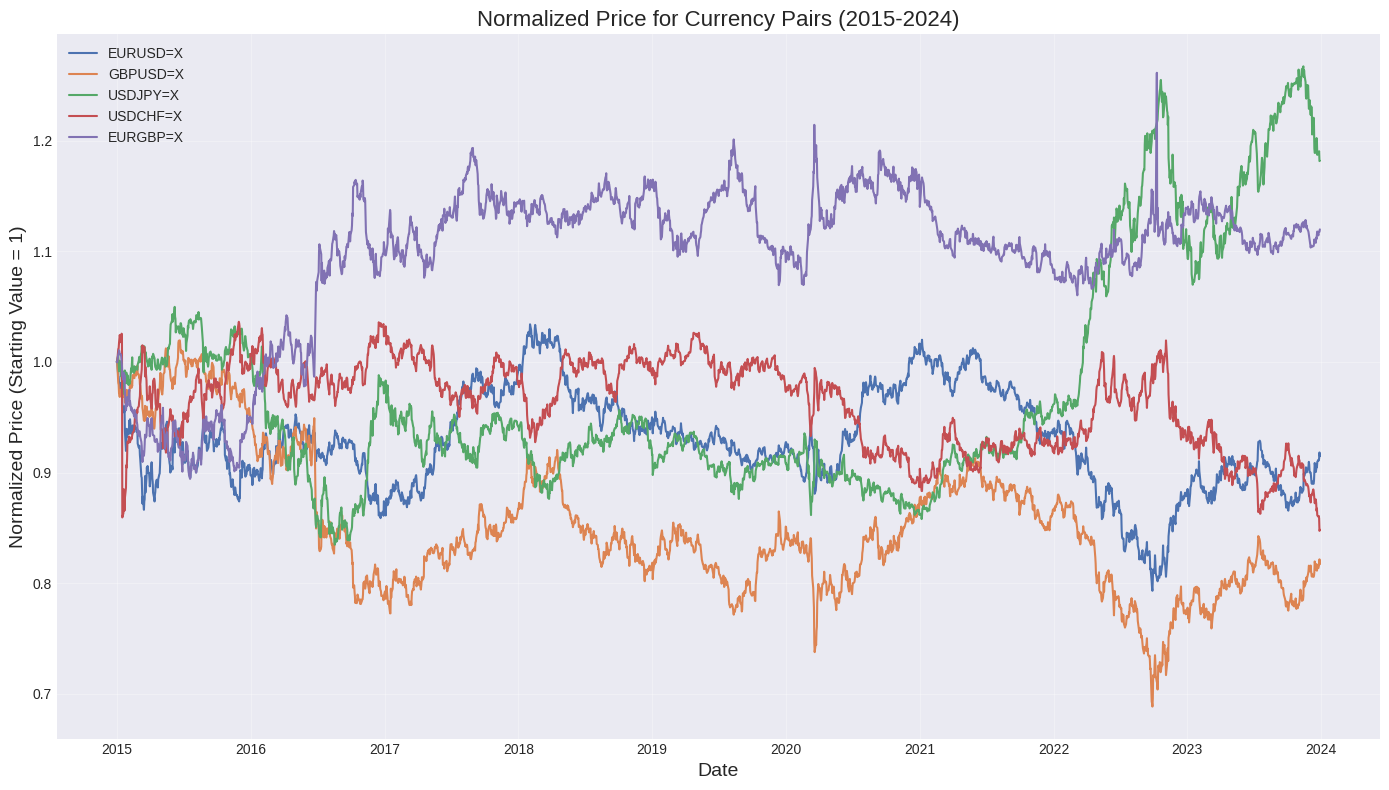

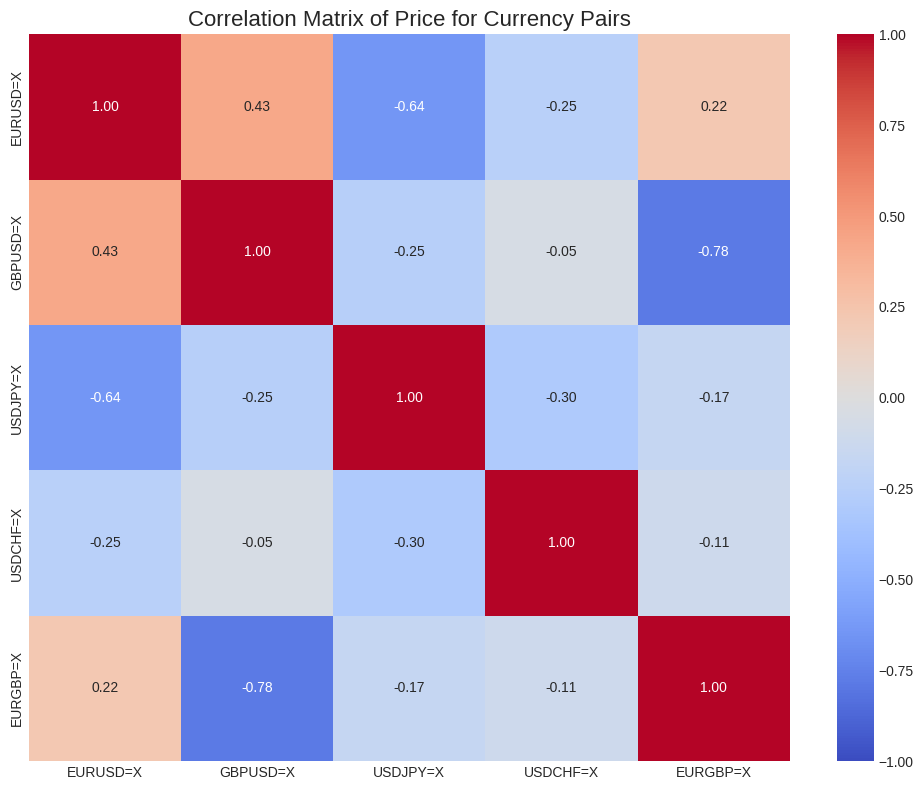

In [ ]:
# Plot the normalized price for all currency pairs
plot_currency_data(data_dict, column='Price')

# Calculate and plot correlation matrix for price
correlation_matrix = plot_correlation_matrix(data_dict, column='Price')

# Step 3: Feature Engineering

In [ ]:
def engineer_features(data, window=30, use_ema=True, pair_name="Unknown"):
    """
    Engineers features, excluding problematic volume features.
    Analyzes NaN distribution before final drop.
    """
    # --- Start of function (numeric coercion, initial checks) ---
    if 'Price' not in data.columns:
        print(f"Error for {pair_name}: Missing 'Price' column.")
        return None
    data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
    # We still keep the Volume column if present, but won't use it for change/rolling features
    if 'Volume' not in data.columns:
        print(f"Warning for {pair_name}: Missing 'Volume' column.")
        data['Volume'] = 0 # Add dummy if missing
    else:
        # Keep original volume data after cleaning, might be useful differently later
        data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce').fillna(0)

    data = data.dropna(subset=['Price'])
    if data.empty:
        print(f"Data empty after numeric coercion/NaN drop for {pair_name}")
        return None

    features = data.copy()
    price_series = features['Price']
    # volume_series = features['Volume'] # Keep volume column but don't derive features from it here
    print(f"Starting feature calculation for {pair_name} with {len(features)} rows.")

    # --- Feature Calculations (Price-based) ---
    features['Rolling_Mean'] = price_series.rolling(window=window).mean().shift(1)
    # REMOVED: features['Rolling_Vol'] = volume_series.rolling(window=window).mean().shift(1)
    features['Spread'] = price_series - features['Rolling_Mean']
    features['Spread_Mean'] = features['Spread'].rolling(window=window).mean().shift(1)
    features['Spread_Std'] = features['Spread'].rolling(window=window).std().shift(1)

    # Z_Score (safe division)
    spread_std_safe = features['Spread_Std'].replace(0, np.nan)
    features['Z_Score'] = (features['Spread'] - features['Spread_Mean']) / spread_std_safe
    features['Z_Score'] = features['Z_Score'].replace([np.inf, -np.inf], np.nan)

    # Log Return (safe division/log)
    with np.errstate(divide='ignore', invalid='ignore'):
        log_returns = np.log(price_series / price_series.shift(1))
    features['Log_Return'] = log_returns.replace([np.inf, -np.inf], np.nan)

    # REMOVED: Volume Change calculation block

    # --- Technical Indicators (Price-based) ---
    try:
        # fillna=False helps see initial TA NaNs, but let's use default True for smoother data
        features['RSI'] = ta.momentum.RSIIndicator(price_series, window=14, fillna=True).rsi()
        macd = ta.trend.MACD(price_series, window_slow=26, window_fast=12, window_sign=9, fillna=True)
        features['MACD'] = macd.macd()
        features['MACD_Signal'] = macd.macd_signal()
        features['MACD_Diff'] = macd.macd_diff()
        bbands = ta.volatility.BollingerBands(price_series, window=20, window_dev=2, fillna=True)
        features['BB_High'] = bbands.bollinger_hband()
        features['BB_Low'] = bbands.bollinger_lband()
        bb_width_calc = (features['BB_High'] - features['BB_Low']) / features['Price']
        features['BB_Width'] = bb_width_calc.replace([np.inf, -np.inf], np.nan) # Safe divide

        if use_ema:
            features['EMA13'] = ta.trend.ema_indicator(price_series, window=13, fillna=True)
            features['EMA34'] = ta.trend.ema_indicator(price_series, window=34, fillna=True)
            features['EMA55'] = ta.trend.ema_indicator(price_series, window=55, fillna=True)
            features['EMA13_above_34'] = (features['EMA13'] > features['EMA34']).astype(float) # Convert boolean to 0/1
            features['EMA13_above_55'] = (features['EMA13'] > features['EMA55']).astype(float)
            features['EMA34_above_55'] = (features['EMA34'] > features['EMA55']).astype(float)

    except Exception as ta_error:
         print(f"!!! Error during TA calculation for {pair_name}: {ta_error}")
         # Define only Price-based TA columns expected
         ta_cols = ['RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low', 'BB_Width']
         if use_ema: ta_cols.extend(['EMA13', 'EMA34', 'EMA55', 'EMA13_above_34', 'EMA13_above_55', 'EMA34_above_55'])
         for col in ta_cols: features[col] = np.nan

    # --- Target Variables ---
    features['Target_Z_Score'] = features['Z_Score'].shift(-1)
    z_score_diff = features['Z_Score'].shift(-1) - features['Z_Score']
    features['Target_Direction'] = np.sign(z_score_diff)

    # --- DEBUG: Analyze NaN distribution BEFORE final drop ---
    print(f"\n--- NaN Analysis for {pair_name} BEFORE final drop (No Vol Features) ---")
    print(f"DataFrame shape: {features.shape}")
    nan_counts = features.isnull().sum()
    # print("NaN counts per column:") # Can be verbose, print only those > 0
    # print(nan_counts)
    print("Columns with any NaNs:")
    print(nan_counts[nan_counts > 0])
    print("----------------------------------------------------\n")

    # --- Strategic NaN Dropping (Revised Feature List) ---
    initial_len = len(features)
    # Define columns that MUST NOT have NaNs (Price-based features only)
    feature_columns = [
        'Rolling_Mean', #'Rolling_Vol', # Removed
        'Spread', 'Spread_Mean', 'Spread_Std', 'Z_Score',
        'Log_Return', #'Vol_Change', # Removed
        'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
        'BB_High', 'BB_Low', 'BB_Width'
    ]
    if use_ema:
        feature_columns.extend([
            'EMA13', 'EMA34', 'EMA55',
            'EMA13_above_34', 'EMA13_above_55', 'EMA34_above_55'
        ])

    # Ensure all defined feature columns actually exist
    existing_feature_columns = [col for col in feature_columns if col in features.columns]
    print(f"Identified {len(existing_feature_columns)} existing feature columns for NaN check.")

    if not existing_feature_columns:
         print(f"Warning: No feature columns found/defined to check for NaNs in {pair_name}. Skipping dropna.")
         features_dropped = features
    else:
         print(f"Dropping rows based on NaNs in {len(existing_feature_columns)} feature columns for {pair_name}...")
         features_dropped = features.dropna(subset=existing_feature_columns)

    final_len = len(features_dropped)
    dropped_count = initial_len - final_len
    print(f"Dropped {dropped_count} rows based on NaNs in feature columns for {pair_name}. Final shape: {features_dropped.shape}")

    if features_dropped.empty and initial_len > 0:
        print(f"!!! All rows were dropped for {pair_name}, even after removing Vol features. Check NaN analysis.")
        return None

    # Fill NaN in Target_Direction just before returning
    if 'Target_Direction' in features_dropped.columns:
         features_dropped['Target_Direction'] = features_dropped['Target_Direction'].fillna(0) # Fill last row NaN

    return features_dropped

In [ ]:
engineered_data = {}
successful_pairs = []

if not data_dict:
     print("\nData dictionary is empty. Cannot proceed with feature engineering.")
else:
    print("\n--- Starting Feature Engineering ---")
    for pair, data in data_dict.items():
        print(f"\nProcessing features for: {pair}")
        if not isinstance(data, pd.DataFrame):
            print(f"Skipping {pair}: Input is not a DataFrame.")
            continue
        if 'Price' not in data.columns or data['Price'].empty:
            print(f"Skipping {pair}: Missing or empty 'Price' column.")
            continue
        if data['Price'].isnull().all():
             print(f"Skipping {pair}: 'Price' column contains only NaNs.")
             continue

        try:
            engineered_df = engineer_features(data.copy(), window=30, use_ema=True, pair_name=pair)

            if engineered_df is not None and not engineered_df.empty:
                engineered_data[pair] = engineered_df
                successful_pairs.append(pair)
                print(f"-> Successfully stored features for {pair}. Shape: {engineered_df.shape}")
                last_row_targets_nan = engineered_df[['Target_Z_Score', 'Target_Direction']].iloc[-1].isnull().any() # Check if *any* target is NaN
                print(f"   Last row target NaNs: {last_row_targets_nan}")
            else:
                 print(f"-> Feature engineering resulted in empty or None DataFrame for {pair}. Skipping storage.") # Function already prints reason

        except Exception as e:
            print(f"!!! Critical Error during feature engineering for {pair}: {e}")
            import traceback
            traceback.print_exc()

# --- Summary ---
print("\n--- Feature Engineering Summary ---")
if successful_pairs:
    print(f"Successfully engineered features for: {', '.join(successful_pairs)}")
    first_successful_pair = successful_pairs[0]
    print(f"\nFeature Statistics for {first_successful_pair}:")
    if first_successful_pair in engineered_data and not engineered_data[first_successful_pair].empty:
        print(engineered_data[first_successful_pair].describe())
    else:
        print(f"Could not display statistics for {first_successful_pair} as its data is missing or empty.")
else:
    print("No currency pair data was successfully engineered.")



--- Starting Feature Engineering ---

Processing features for: EURUSD=X
Starting feature calculation for EURUSD=X with 2344 rows.

--- NaN Analysis for EURUSD=X BEFORE final drop (No Vol Features) ---
DataFrame shape: (2344, 23)
Columns with any NaNs:
Rolling_Mean        30
Spread              30
Spread_Mean         60
Spread_Std          60
Z_Score             60
Log_Return           1
Target_Z_Score      60
Target_Direction    61
dtype: int64
----------------------------------------------------

Identified 19 existing feature columns for NaN check.
Dropping rows based on NaNs in 19 feature columns for EURUSD=X...
Dropped 60 rows based on NaNs in feature columns for EURUSD=X. Final shape: (2284, 23)
-> Successfully stored features for EURUSD=X. Shape: (2284, 23)
   Last row target NaNs: True

Processing features for: GBPUSD=X
Starting feature calculation for GBPUSD=X with 2344 rows.

--- NaN Analysis for GBPUSD=X BEFORE final drop (No Vol Features) ---
DataFrame shape: (2344, 23)
Col

In [ ]:
# --- Post-Processing Summary ---
print("\n--- Feature Engineering Summary ---")
if successful_pairs:
    print(f"Successfully engineered features for: {', '.join(successful_pairs)}")
    # Examine feature distribution for the first successful pair
    first_successful_pair = successful_pairs[0]
    print(f"\nFeature Statistics for {first_successful_pair}:")
    # Add a check if the dataframe exists and is not empty before describe()
    if first_successful_pair in engineered_data and not engineered_data[first_successful_pair].empty:
        print(engineered_data[first_successful_pair].describe())
    else:
        print(f"Could not display statistics for {first_successful_pair} as its data is missing or empty.")



--- Feature Engineering Summary ---
Successfully engineered features for: EURUSD=X, GBPUSD=X, USDJPY=X, USDCHF=X, EURGBP=X

Feature Statistics for EURUSD=X:
             Price  Volume  Rolling_Mean       Spread  Spread_Mean  \
count  2284.000000  2284.0   2284.000000  2284.000000  2284.000000   
mean      1.123001     0.0      1.122970     0.000031    -0.000280   
std       0.053554     0.0      0.052381     0.015825     0.011750   
min       0.959619     0.0      0.981365    -0.047200    -0.030993   
25%       1.088400     0.0      1.088747    -0.010656    -0.008202   
50%       1.120298     0.0      1.118571    -0.000893    -0.001135   
75%       1.164229     0.0      1.164588     0.010406     0.007561   
max       1.251001     0.0      1.235596     0.057221     0.032566   

        Spread_Std      Z_Score   Log_Return          RSI         MACD  ...  \
count  2284.000000  2284.000000  2284.000000  2284.000000  2284.000000  ...   
mean      0.010432     0.009932     0.000007    49.59

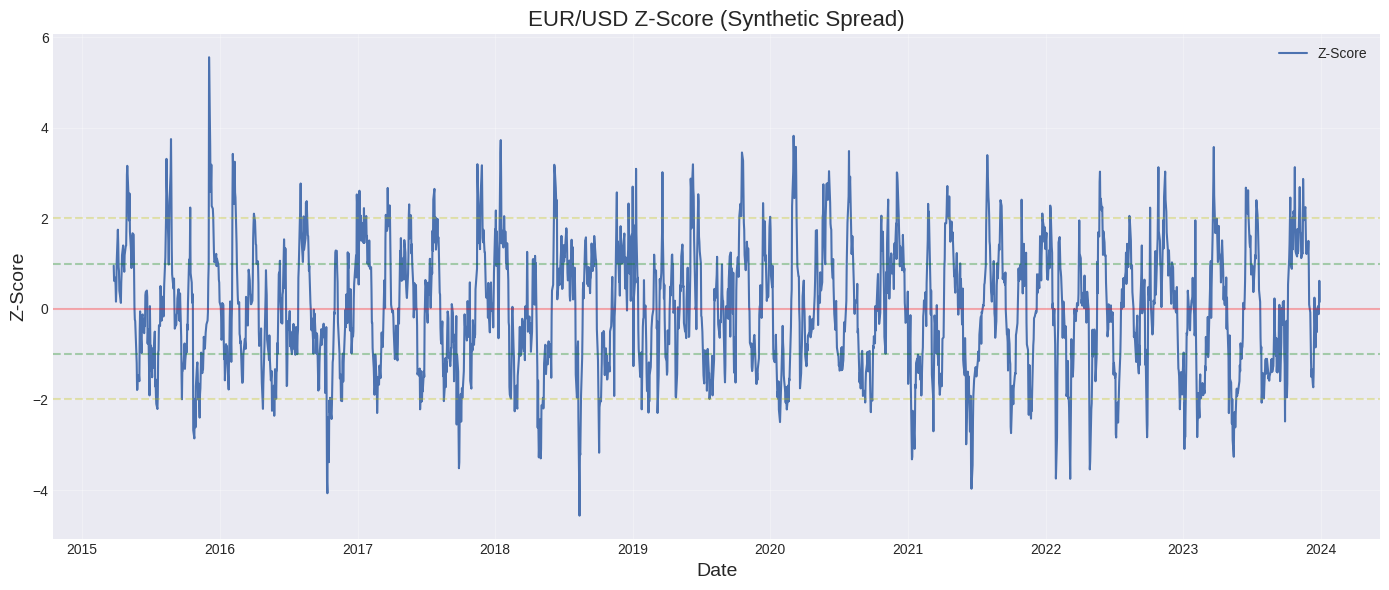

In [ ]:
# Visualize the Z-Score for EURUSD
plt.figure(figsize=(14, 6))
plt.plot(engineered_data['EURUSD=X']['Z_Score'], label='Z-Score')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axhline(y=1, color='g', linestyle='--', alpha=0.3)
plt.axhline(y=-1, color='g', linestyle='--', alpha=0.3)
plt.axhline(y=2, color='y', linestyle='--', alpha=0.3)
plt.axhline(y=-2, color='y', linestyle='--', alpha=0.3)
plt.title('EUR/USD Z-Score (Synthetic Spread)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Z-Score', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 4: Feature Selection and Data Preparation

In [ ]:
def prepare_data_for_ml(features, target_col='Target_Z_Score', test_size=0.2):
    """
    Prepares data for machine learning models.
    """
    # Drop columns we don't want to use as features
    drop_cols = ['Target_Z_Score', 'Target_Direction', 'Price', 'Volume']
    X = features.drop(columns=drop_cols)
    y = features[target_col]

    # Use time-based split instead of random split
    train_size = int((1 - test_size) * len(features))
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

    return X_train, X_test, y_train, y_test

In [ ]:
# Let's focus on EURUSD for modeling
pair = 'EURUSD=X'
X_train, X_test, y_train, y_test = prepare_data_for_ml(engineered_data[pair], target_col='Target_Z_Score')

Training set size: (1827, 19), Test set size: (457, 19)


In [ ]:
# Feature importance plot function
def plot_feature_importance(model, X_train, title):
    """
    Plots feature importance for tree-based models.
    """
    # Get feature importance
    importance = model.feature_importances_
    # Sort feature importance in descending order
    sorted_idx = np.argsort(importance)[::-1]

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
    plt.title(title, fontsize=16)
    plt.xlabel('Feature Importance', fontsize=14)
    plt.tight_layout()
    plt.show()

# Step 5: Model Training and Evaluation

In [ ]:
# Function to evaluate regression models
def evaluate_regression_model(y_true, y_pred, model_name):
    """
    Evaluates regression model performance using multiple metrics.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_true.values, label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f'{model_name}: Actual vs Predicted Z-Score', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Z-Score', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot scatter plot of actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.title(f'{model_name}: Scatter Plot of Actual vs Predicted', fontsize=16)
    plt.xlabel('Actual', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

## 5.1: Random Forest Regression

In [ ]:
# rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# rf_model.fit(X_train, y_train)
# rf_pred = rf_model.predict(X_test)
# rf_metrics = evaluate_regression_model(y_test, rf_pred, "Random Forest")

Training set size: (1827, 19), Test set size: (457, 19)

Original y_test length: 457
Original rf_pred length: 457
Filtered y_test length: 456
Filtered rf_pred length: 456
Random Forest Performance Metrics:
MSE: 0.395868
RMSE: 0.629181
MAE: 0.469814
R²: 0.801765


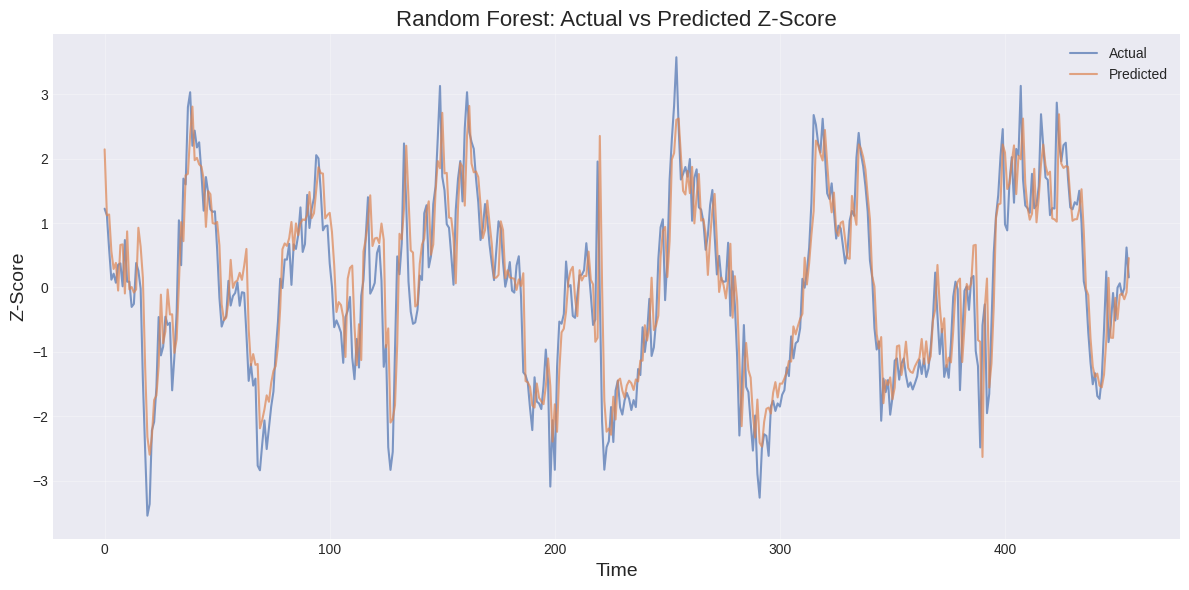

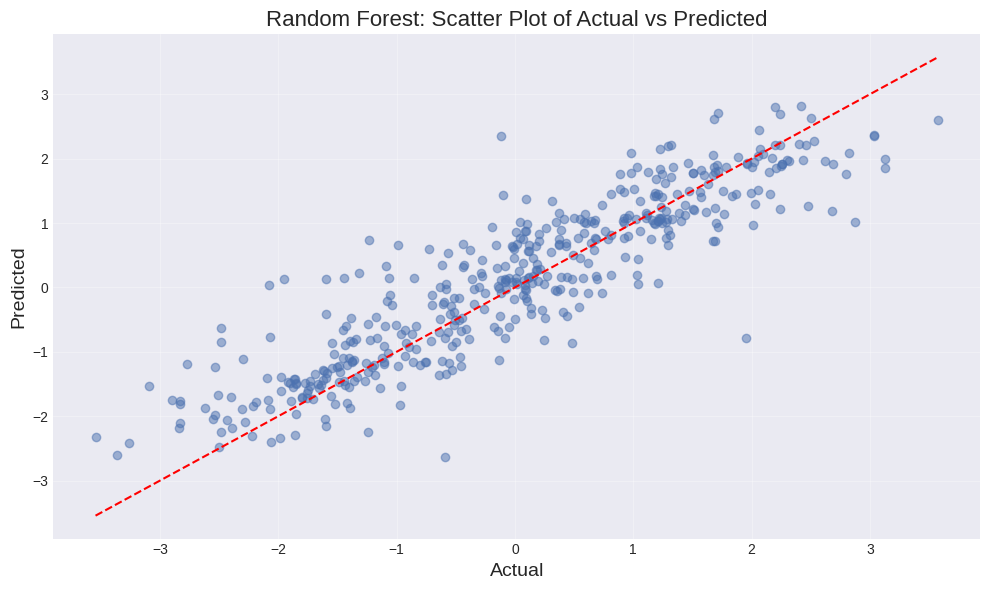

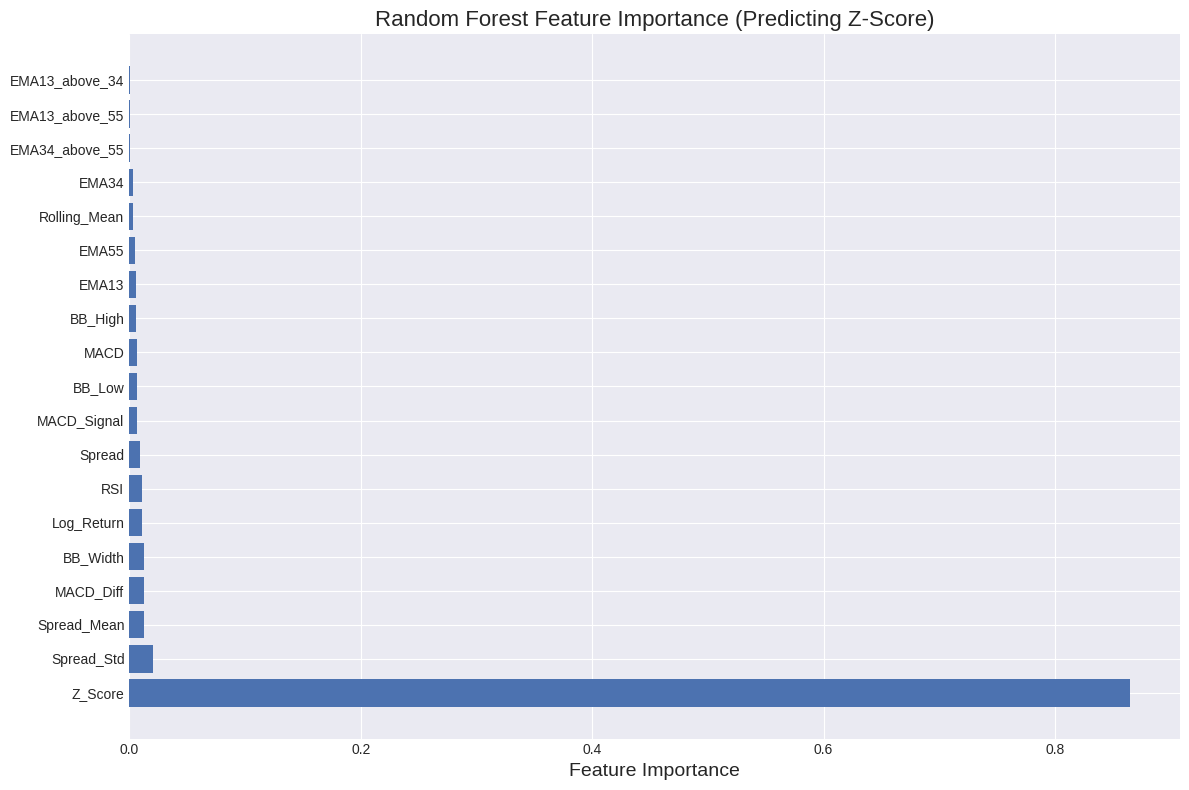

In [ ]:
# Let's focus on EURUSD for modeling
# pair = 'EURUSD=X'
# if pair in engineered_data:
X_train, X_test, y_train, y_test = prepare_data_for_ml(
    engineered_data[pair], target_col='Target_Z_Score'
)

# --- Pre-prediction NaN Check (Good Practice) ---
if X_test.isnull().sum().sum() > 0:
      print("!!! Warning: NaNs found in X_test features before prediction. This shouldn't happen.")
      print(X_test.isnull().sum()[X_test.isnull().sum() > 0])
      # Option: Fill remaining NaNs if absolutely necessary, though finding the cause is better
      # X_test = X_test.fillna(method='ffill').fillna(method='bfill') # Example fill
# --- End NaN Check ---


## 5.1: Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1) # Added n_jobs
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# --- FIX: Remove NaN targets and corresponding predictions BEFORE evaluation ---
print(f"\nOriginal y_test length: {len(y_test)}")
print(f"Original rf_pred length: {len(rf_pred)}")

# Identify indices in y_test that are NOT NaN
valid_indices = y_test.notna()

# Filter y_test and rf_pred
y_test_filtered = y_test[valid_indices]
# rf_pred is likely a numpy array, needs boolean indexing
rf_pred_filtered = rf_pred[valid_indices.values] # Use .values if valid_indices is a Series

print(f"Filtered y_test length: {len(y_test_filtered)}")
print(f"Filtered rf_pred length: {len(rf_pred_filtered)}")

# Check if any data remains after filtering
if len(y_test_filtered) == 0:
      print("!!! Error: No valid (non-NaN) target values remain in the test set after filtering.")
else:
    # Pass the filtered arrays to the evaluation function
    rf_metrics = evaluate_regression_model(y_test_filtered, rf_pred_filtered, "Random Forest")

    # Plot feature importance (can still use original X_train)
    plot_feature_importance(rf_model, X_train, "Random Forest Feature Importance (Predicting Z-Score)")

# --- Continue with other models (XGBoost, LSTM) using the same filtering logic ---
# ... (example for XGBoost) ...
# xgb_model = XGBRegressor(...)
# xgb_model.fit(X_train, y_train)
# xgb_pred = xgb_model.predict(X_test)
# xgb_pred_filtered = xgb_pred[valid_indices.values] # Use same valid_indices
# xgb_metrics = evaluate_regression_model(y_test_filtered, xgb_pred_filtered, "XGBoost")
# plot_feature_importance(xgb_model, X_train, "XGBoost Feature Importance...")

# else:
#     print(f"Data for selected pair {pair} not found in engineered_data.")

## 5.2: XGBoost Regression

XGBoost Performance Metrics:
MSE: 0.433958
RMSE: 0.658755
MAE: 0.487309
R²: 0.782692


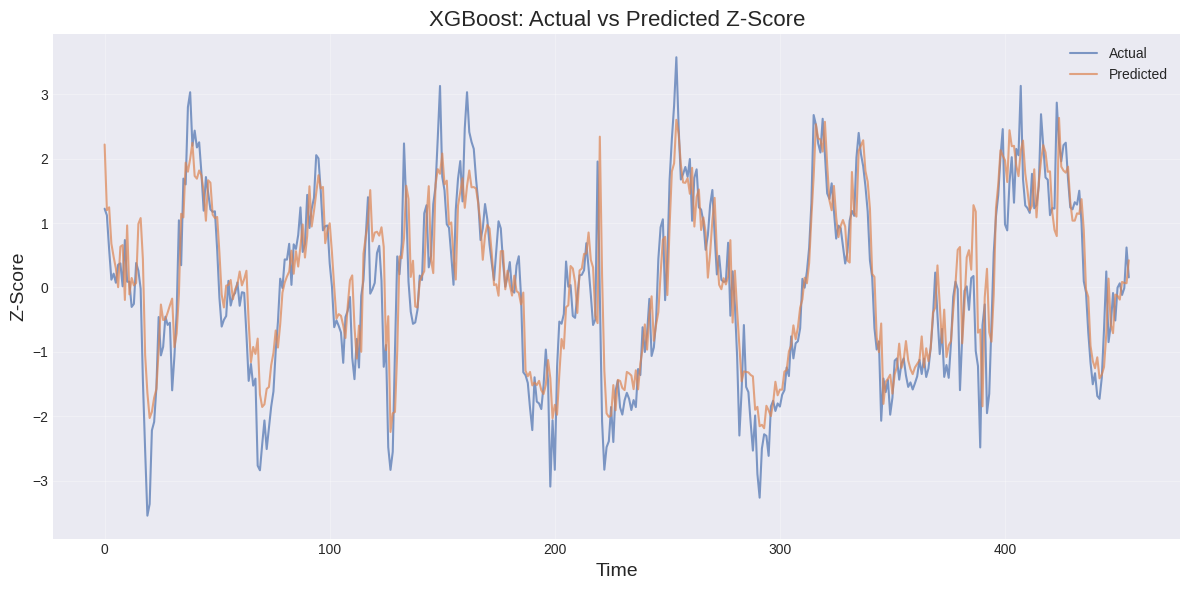

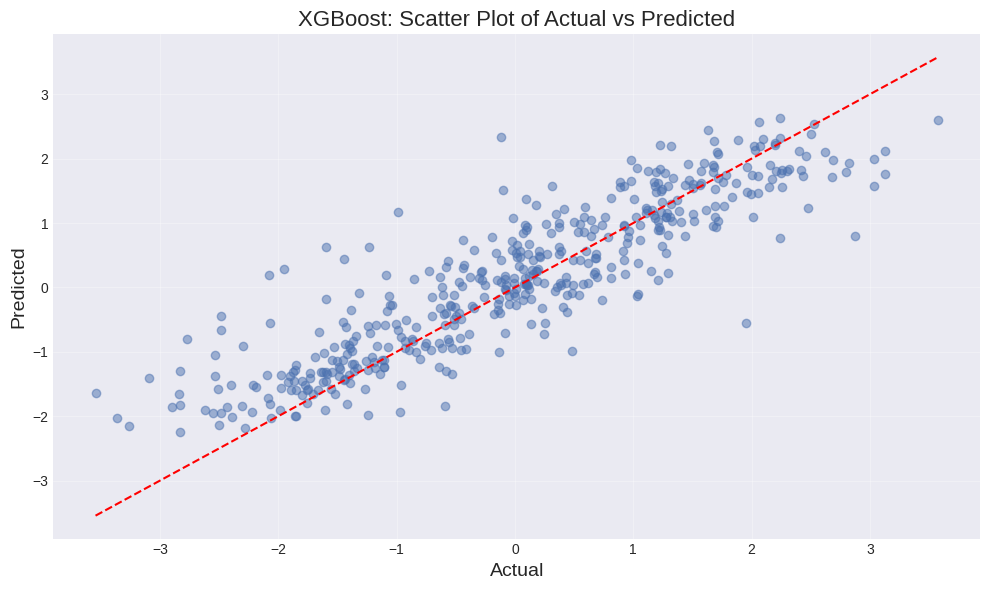

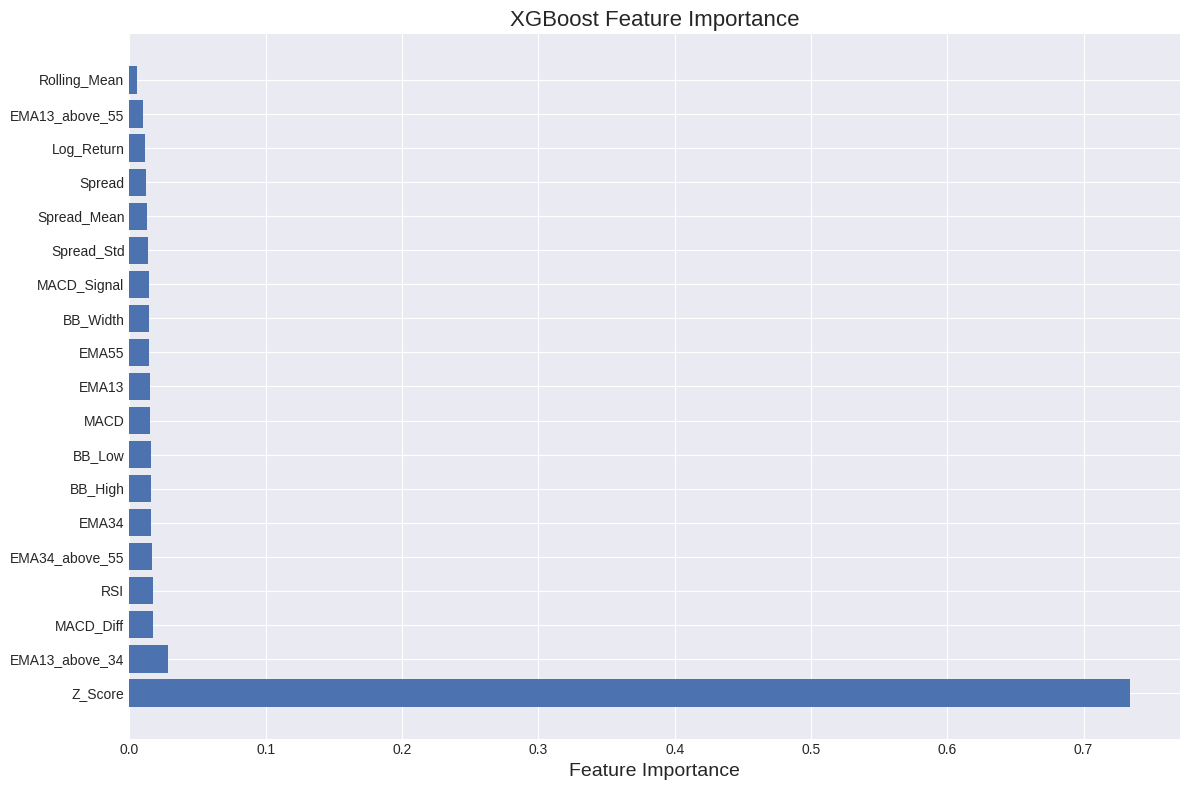

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred_filtered = xgb_pred[valid_indices.values] # Use same valid_indices
xgb_metrics = evaluate_regression_model(y_test_filtered, xgb_pred_filtered, "XGBoost")
plot_feature_importance(xgb_model, X_train, "XGBoost Feature Importance")

## 5.3: Basic Trading Strategy Simulation

In [ ]:
def simulate_trading_strategy(data, z_score_predictions, threshold=1.0):
    """
    Simulates a basic trading strategy based on Z-score predictions.

    Strategy:
    - If Z-score < -threshold: Go long (buy)
    - If Z-score > threshold: Go short (sell)
    - If -threshold <= Z-score <= threshold: Close position

    Returns DataFrame with positions and profit/loss.
    """
    # Create a copy of the data for simulation
    sim_data = data.iloc[len(data) - len(z_score_predictions):].copy()

    # Add Z-score predictions
    sim_data['Z_Score_Pred'] = z_score_predictions

    # Generate trading signals
    sim_data['Signal'] = 0  # 0: no position, 1: long, -1: short
    sim_data.loc[sim_data['Z_Score_Pred'] < -threshold, 'Signal'] = 1
    sim_data.loc[sim_data['Z_Score_Pred'] > threshold, 'Signal'] = -1

    # Calculate position changes
    sim_data['Position_Change'] = sim_data['Signal'].diff()

    # Calculate returns (assuming fixed percentage move per position)
    sim_data['Return'] = 0.0
    sim_data.loc[sim_data['Signal'] == 1, 'Return'] = sim_data.loc[sim_data['Signal'] == 1, 'Log_Return']
    sim_data.loc[sim_data['Signal'] == -1, 'Return'] = -sim_data.loc[sim_data['Signal'] == -1, 'Log_Return']

    # Calculate cumulative returns
    sim_data['Cum_Return'] = (1 + sim_data['Return']).cumprod()

    # Calculate buy and hold returns for comparison
    sim_data['Buy_Hold_Return'] = (1 + sim_data['Log_Return']).cumprod()

    return sim_data

In [ ]:
# Run simulation with Random Forest predictions
rf_sim = simulate_trading_strategy(engineered_data[pair], rf_pred, threshold=1.0)

In [ ]:
# Run simulation with XGBoost predictions
xgb_sim = simulate_trading_strategy(engineered_data[pair], xgb_pred, threshold=1.0)

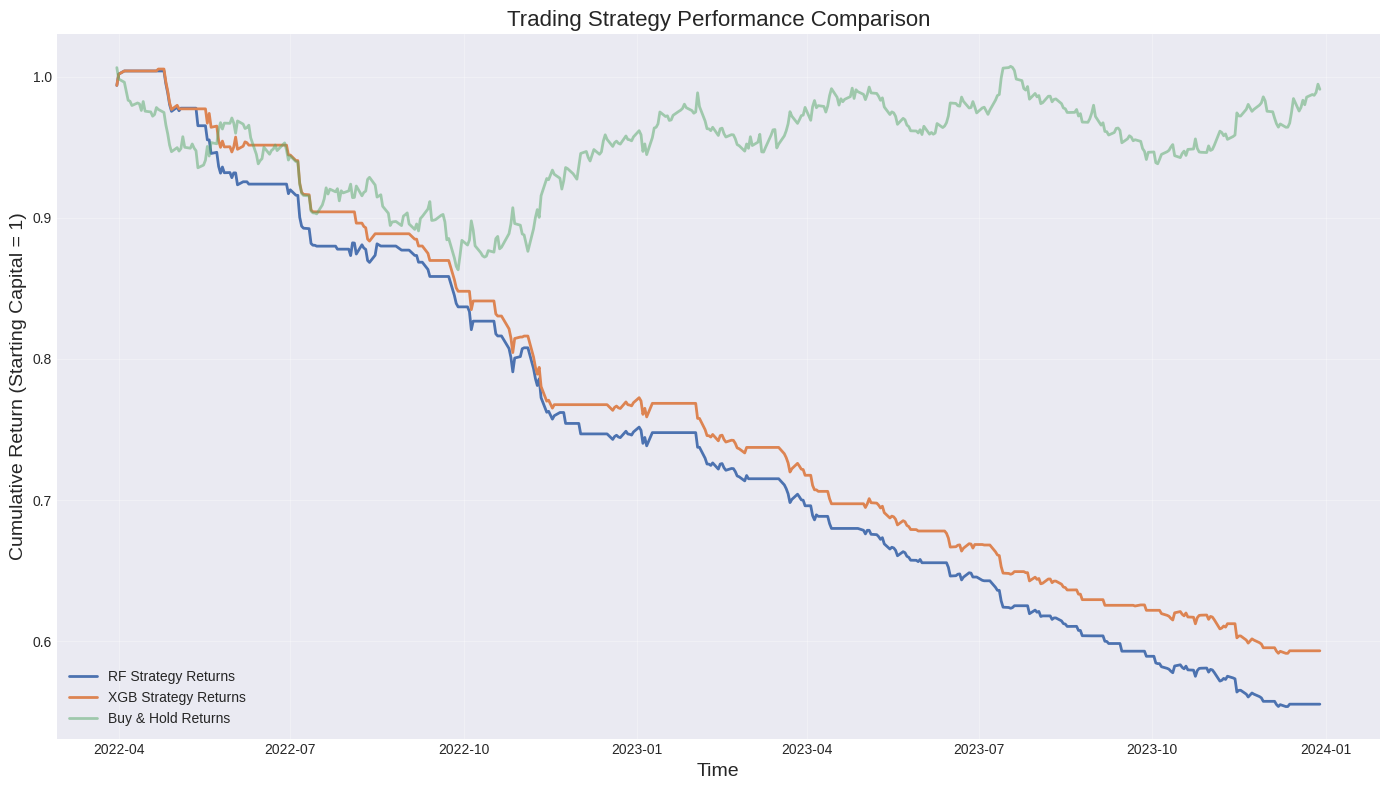

In [ ]:
# Plot trading strategy results
plt.figure(figsize=(14, 8))
plt.plot(rf_sim['Cum_Return'], label='RF Strategy Returns', linewidth=2)
plt.plot(xgb_sim['Cum_Return'], label='XGB Strategy Returns', linewidth=2)
plt.plot(rf_sim['Buy_Hold_Return'], label='Buy & Hold Returns', linewidth=2, alpha=0.5)
plt.title('Trading Strategy Performance Comparison', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Cumulative Return (Starting Capital = 1)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 6: Cross-validation for Time Series

In [ ]:
def time_series_cv(X, y, model, cv=5):
    """
    Performs time series cross-validation for regression models.
    """
    tscv = TimeSeriesSplit(n_splits=cv)
    cv_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)

        cv_scores.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))

    return cv_scores

In [ ]:
# Cross-validation for Random Forest
rf_cv_scores = time_series_cv(X_train, y_train, RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
print(f"Random Forest CV RMSE Scores: {rf_cv_scores}")
print(f"Random Forest CV Average RMSE: {np.mean(rf_cv_scores):.6f}")

Random Forest CV RMSE Scores: [np.float64(0.8170288383666802), np.float64(0.7247787378414373), np.float64(0.8149579995105554), np.float64(0.5846694323850545), np.float64(0.610645887624034)]
Random Forest CV Average RMSE: 0.710416


In [ ]:
# Cross-validation for XGBoost
xgb_cv_scores = time_series_cv(X_train, y_train, XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42))
print(f"XGBoost CV RMSE Scores: {xgb_cv_scores}")
print(f"XGBoost CV Average RMSE: {np.mean(xgb_cv_scores):.6f}")

XGBoost CV RMSE Scores: [np.float64(0.8279053932537941), np.float64(0.739530399361153), np.float64(0.9222227526268585), np.float64(0.6139703247087034), np.float64(0.6599808733845021)]
XGBoost CV Average RMSE: 0.752722


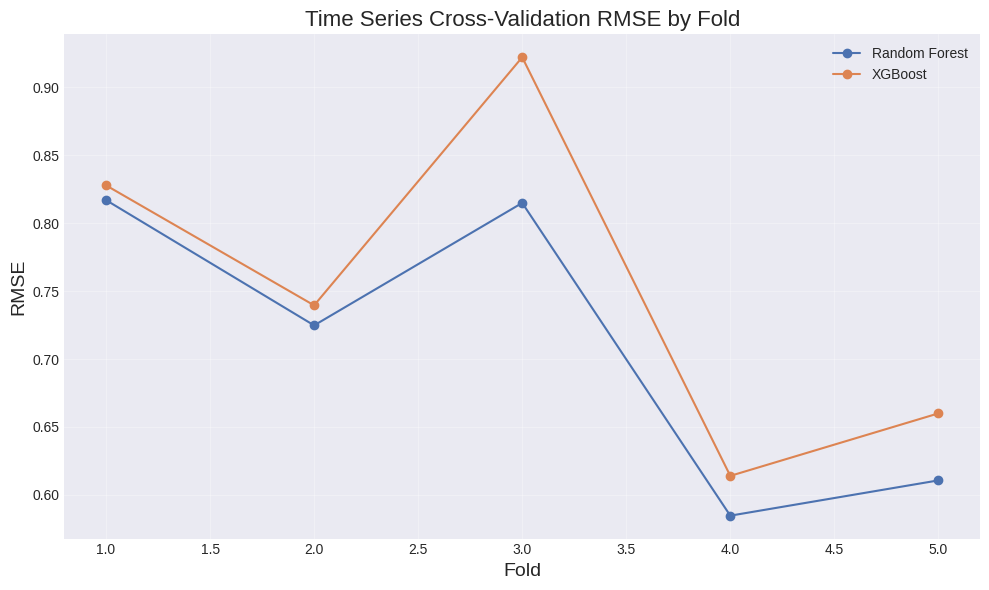

In [ ]:
# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rf_cv_scores) + 1), rf_cv_scores, 'o-', label='Random Forest')
plt.plot(range(1, len(xgb_cv_scores) + 1), xgb_cv_scores, 'o-', label='XGBoost')
plt.title('Time Series Cross-Validation RMSE by Fold', fontsize=16)
plt.xlabel('Fold', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()